In [59]:
import DSGRN
import DSGRN_utils
import dsgrn_boolean

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import json
from dsgrn_boolean.utils.newton import newton_method
from dsgrn_boolean.models.hill import HillFunction

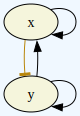

In [61]:
net_spec = """x : x + y : E
              y : (~x) y : E"""

network = DSGRN.Network(net_spec)

DSGRN.DrawGraph(network)

In [62]:
parameter_graph = DSGRN.ParameterGraph(network)

print('Number of parameter nodes:', parameter_graph.size())

Number of parameter nodes: 196


In [63]:
# %%time

# # Isomorphism classes
# iso_classes = DSGRN_utils.IsomorphismQuery(network)

# # Create isomorphic node classes to color the nodes
# node_classes = {k: iso_classes[k] for k in range(len(iso_classes))}

In [64]:
par_list = [0, 49, 98, 147]

In [65]:
# for par_index in par_list:
#     parameter = parameter_graph.parameter(par_index)

#     morse_graph, stg, graded_complex = DSGRN_utils.ConleyMorseGraph(parameter)

#     # DSGRN_utils.PlotMorseGraph(morse_graph)
#     DSGRN_utils.PlotMorseSets(morse_graph, stg, graded_complex)

In [66]:
# for par_index in par_list:
#     parameter = parameter_graph.parameter(par_index)

#     morse_graph, stg, graded_complex = DSGRN_utils.ConleyMorseGraph(parameter)

#     DSGRN_utils.PlotMorseGraph(morse_graph)
#     DSGRN_utils.PlotMorseSets(morse_graph, stg, graded_complex)

In [67]:
# for par_index in par_list:
#     print("Parameter:", par_index)
#     parameter = parameter_graph.parameter(par_index)
#     print(parameter.partialorders('T'))

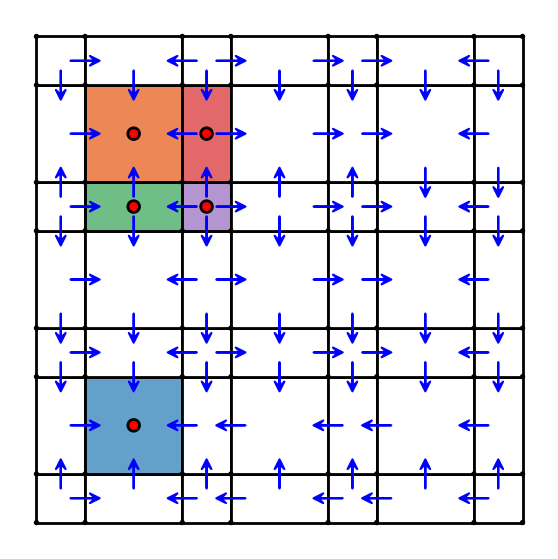

In [68]:
par_index = 0
parameter = parameter_graph.parameter(par_index)

morse_graph, stg, graded_complex = DSGRN_utils.ConleyMorseGraph(parameter)

DSGRN_utils.PlotMorseGraph(morse_graph)
DSGRN_utils.PlotMorseSets(morse_graph, stg, graded_complex)
sampler = DSGRN.ParameterSampler(network)
par_sample = sampler.sample(parameter)

In [69]:
# Define L, U, and T from sample
D = network.size()
L = np.zeros([D, D])
U = np.zeros([D, D])
T = np.zeros([D, D])

# Get a dictionary from sample
sample_dict = json.loads(par_sample)

# Get values of L, U, and T from dictionary
for key, value in sample_dict['Parameter'].items():
    # Get parameter (L, U, or T)
    par_type = key[0]
    # Extract variable names
    node_names = [name.strip() for name in key[2:-1].split('->')]
    node_indices = [network.index(node) for node in node_names]
    if par_type == 'L':
        L[tuple(node_indices)] = value
    elif par_type == 'U':
        U[tuple(node_indices)] = value
    else: # T
        T[tuple(node_indices)] = value

In [71]:
def hill(L, U, T, d):
    """
    Creates the system of differential equations with parameter d
    """
    # Create Hill functions
    h11 = HillFunction(L[0,0], U[0,0], T[0,0], d)
    h21 = HillFunction(L[1,0], U[1,0], T[1,0], d)
    h12 = HillFunction(U[0,1], L[0,1], T[0,1], d)
    h22 = HillFunction(L[1,1], U[1,1], T[1,1], d)

    def system(x):
        # x is a vector
        x1, x2 = x
        
        # First equation: x1'
        dx1 = -x1 + h11(x1) + h21(x2)
        
        # Second equation: x2
        dx2 = -x2 + h12(x1) * h22(x2)
        
        return np.array([dx1, dx2])
    
    def jacobian(x):
        x1, x2 = x
        
        # Compute derivatives
        dh11 = h11.derivative(x1)
        dh21 = h21.derivative(x2)
        dh12 = h12.derivative(x1)
        dh22 = h22.derivative(x2)
        
        # Jacobian matrix
        J = np.zeros((2, 2))
        
        # df1/dx1
        J[0,0] = -1 + dh11
        # df1/dx2
        J[0,1] = dh21
        
        # df2/dx1
        J[1,0] = dh12 * h22(x2)
        # df2/dx2
        J[1,1] = -1 + h12(x1) * dh22
        
        return np.array(J)
    
    return system, jacobian

In [72]:

def plot_nullclines(L, U, T, d, n_points=1000):
    """
    Plot nullclines of the system:
    x' = -x + h11(x) + h21(y)
    y' = -y + h12(x) * h22(y)
    """
    # Create Hill functions
    h11 = HillFunction(L[0,0], U[0,0], T[0,0], d)
    h21 = HillFunction(L[1,0], U[1,0], T[1,0], d)
    h12 = HillFunction(U[0,1], L[0,1], T[0,1], d)
    h22 = HillFunction(L[1,1], U[1,1], T[1,1], d)
    
    # Create grid
    x_max = 1.5*(U[0,0] + U[1,0])
    y_max = 1.5*(U[0,1] * U[1,1])
    x = np.linspace(0, x_max, n_points)
    y = np.linspace(0, y_max, n_points)
    X, Y = np.meshgrid(x, y)
    
    # First nullcline: x' = 0 => x = h11(x) + h21(y)
    Z1 = h11(X) + h21(Y) - X
    
    # Second nullcline: y' = 0 => y = h12(x) * h22(y)
    Z2 = h12(X) * h22(Y) - Y
    
    # Plot
    plt.figure(figsize=(10, 10))
    plt.contour(X, Y, Z1, levels=[0], colors='blue', label="x' = 0")
    plt.contour(X, Y, Z2, levels=[0], colors='red', label="y' = 0")
    
    # Set axis limits explicitly
    plt.xlim(0, x_max)
    plt.ylim(0, y_max)
    
    # Add labels and legend
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Nullclines')
    plt.legend()
    plt.grid(True)
    
    # Add intersections (equilibria)
    system, jacobian = hill(L, U, T, d)
    
    # Find zeros using newton method
    n_grid = 20  # coarser grid for initial conditions
    x_grid = np.linspace(0, x_max, n_grid)
    y_grid = np.linspace(0, y_max, n_grid)
    initial_conditions = [np.array([x, y]) for x in x_grid for y in y_grid]
    
    zeros = []
    for x0 in initial_conditions:
        x, converged, _ = newton_method(system, x0, df=jacobian)
        if converged:
            # Check if this zero is already found
            is_new = True
            for z in zeros:
                if np.allclose(z, x, rtol=1e-5):
                    is_new = False
                    break
            if is_new:
                zeros.append(x)
                # Get stability
                J = jacobian(x)
                eigenvals = np.linalg.eigvals(J)
                stable = all(np.real(eigenvals) < 0)
                # Plot stable points as filled circles, unstable as empty circles
                if stable:
                    plt.plot(x[0], x[1], 'ko', markersize=10, label='Stable equilibrium' if len(zeros)==1 else "")
                else:
                    plt.plot(x[0], x[1], 'ko', fillstyle='none', markersize=10, label='Unstable equilibrium' if len(zeros)==1 else "")
    
    plt.legend()
    plt.show()
    
    return zeros

/var/folders/l4/bscnrsc979b_sm33lvwtr24r0000gr/T/ipykernel_64809/851068030.py:28: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z1, levels=[0], colors='blue', label="x' = 0")
/var/folders/l4/bscnrsc979b_sm33lvwtr24r0000gr/T/ipykernel_64809/851068030.py:29: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z2, levels=[0], colors='red', label="y' = 0")
/var/folders/l4/bscnrsc979b_sm33lvwtr24r0000gr/T/ipykernel_64809/851068030.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


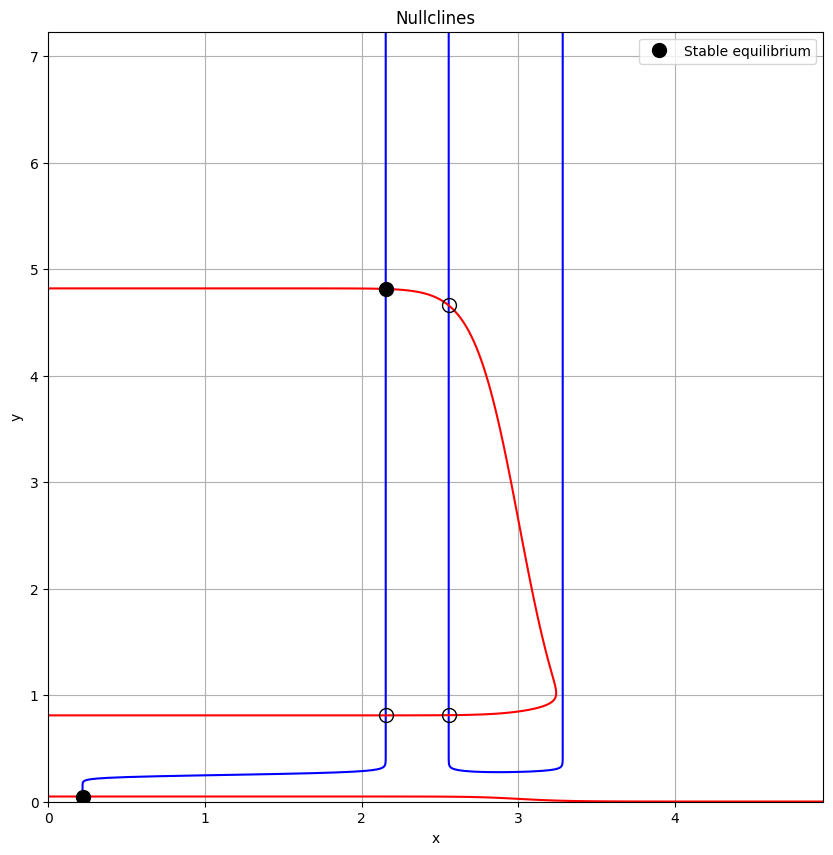

In [79]:
# for d in [5.0, 10.0, 20.0]:
#     plot_nullclines(L, U, T, d)
zeros = plot_nullclines(L, U, T, 20.0)

In [75]:
DSGRN.EquilibriumCells(parameter)

[[(1, 2), (0, 0)],
 [(0, 2), (1, 0)],
 [(1, 2), (0, 1)],
 [(0, 0), (1, 1)],
 [(0, 2), (1, 1)]]

None


/var/folders/l4/bscnrsc979b_sm33lvwtr24r0000gr/T/ipykernel_64809/851068030.py:28: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z1, levels=[0], colors='blue', label="x' = 0")
/var/folders/l4/bscnrsc979b_sm33lvwtr24r0000gr/T/ipykernel_64809/851068030.py:29: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z2, levels=[0], colors='red', label="y' = 0")
/var/folders/l4/bscnrsc979b_sm33lvwtr24r0000gr/T/ipykernel_64809/851068030.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


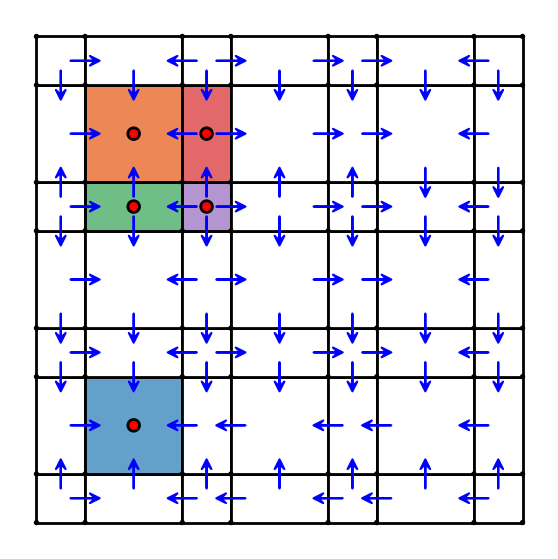

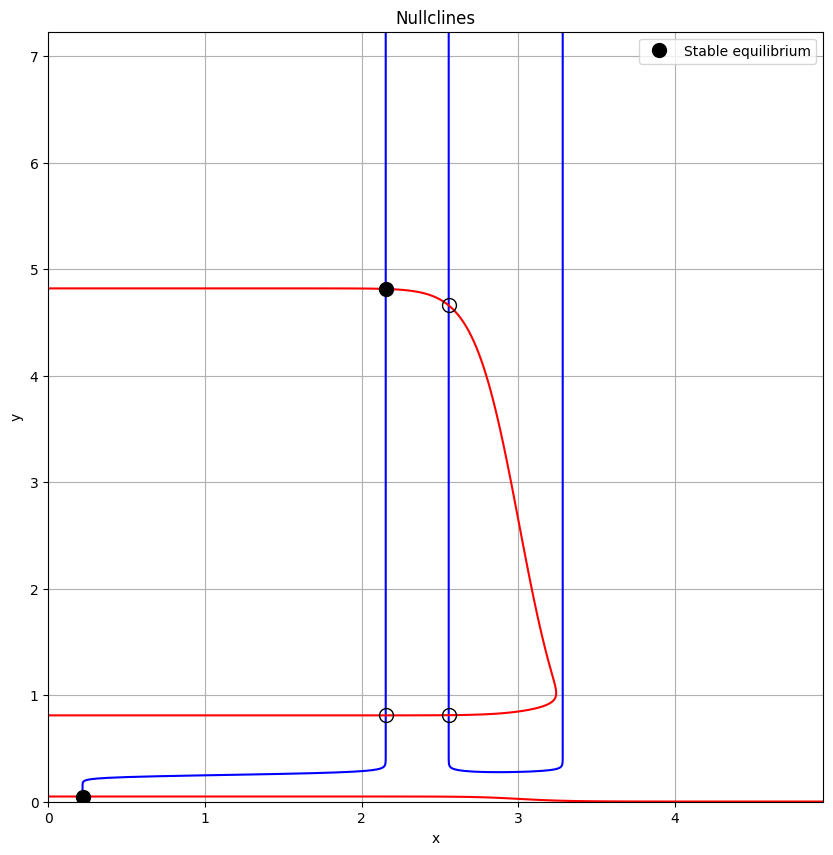

None


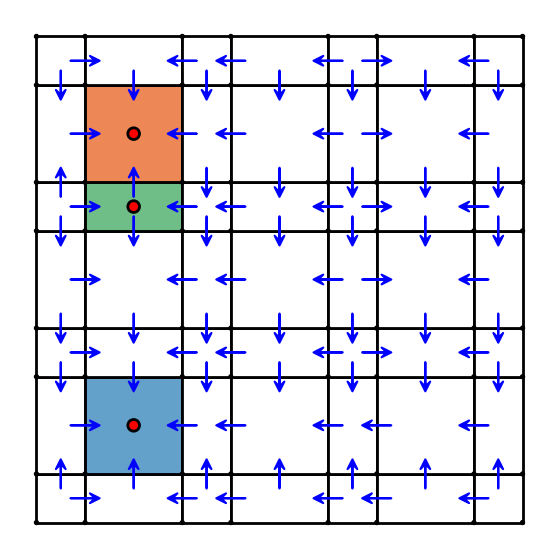

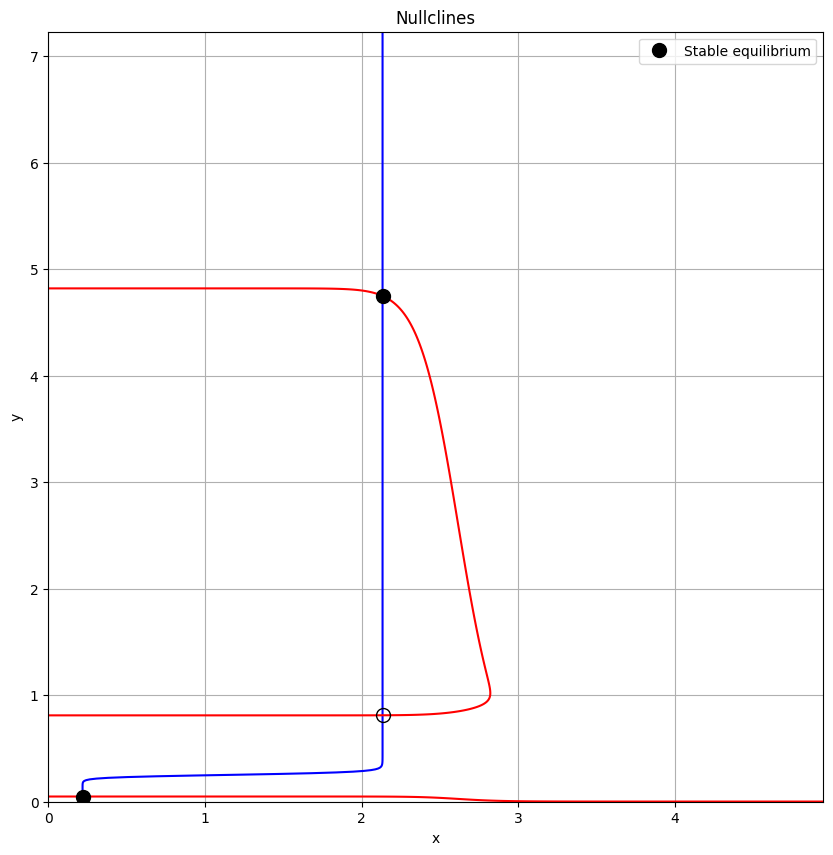

None


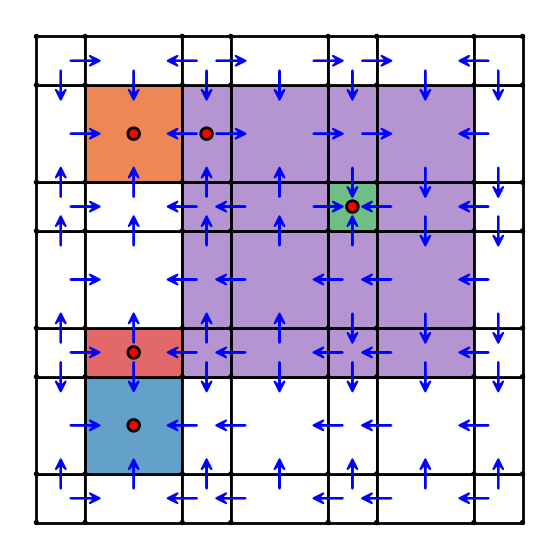

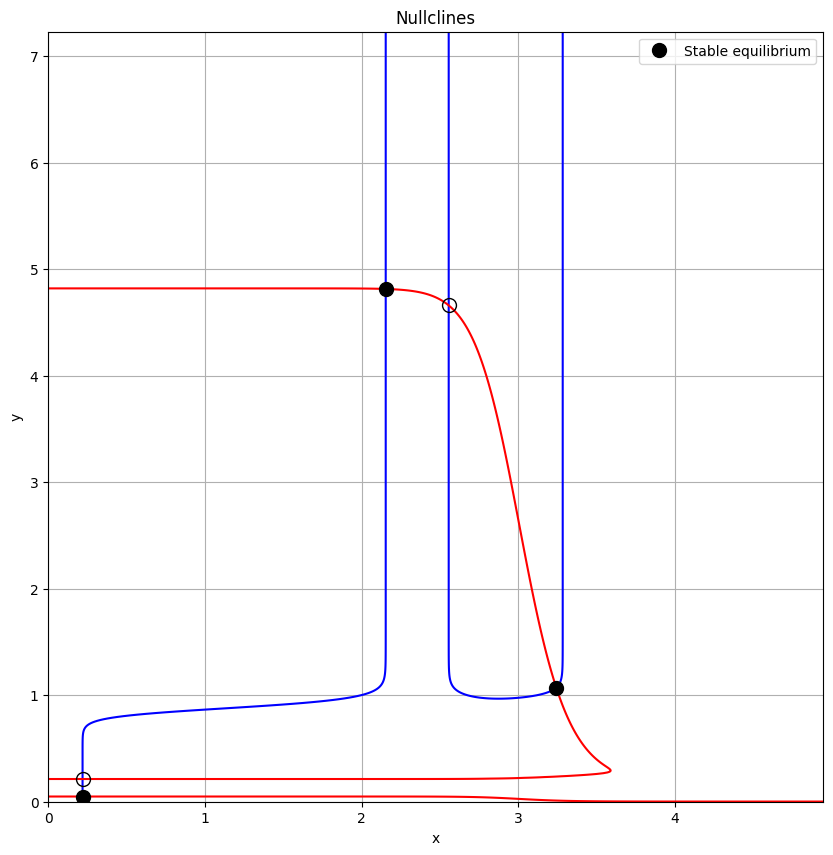

None


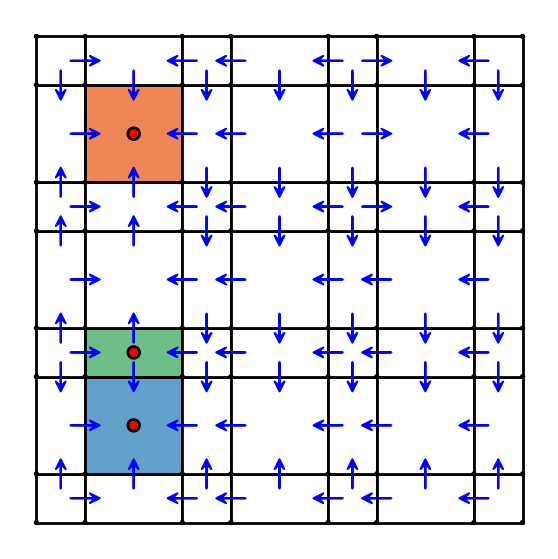

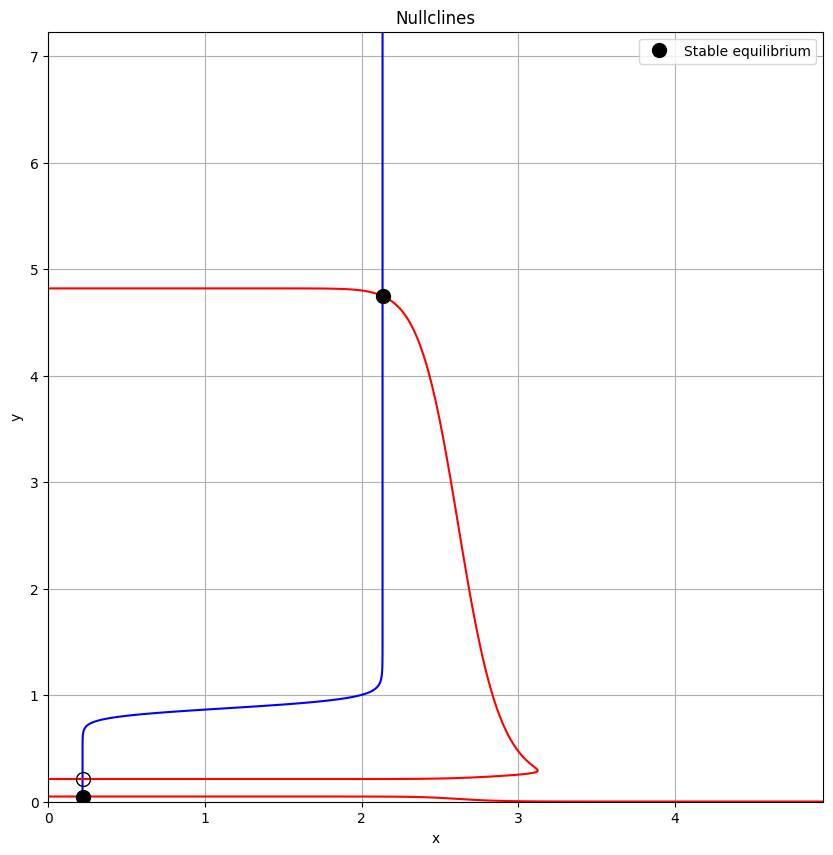

In [82]:
for par_index in par_list:
    parameter = parameter_graph.parameter(par_index)

    morse_graph, stg, graded_complex = DSGRN_utils.ConleyMorseGraph(parameter)

    print(DSGRN_utils.PlotMorseSets(morse_graph, stg, graded_complex))
    sampler = DSGRN.ParameterSampler(network)
    par_sample = sampler.sample(parameter)
    # Define L, U, and T from sample
    D = network.size()
    L = np.zeros([D, D])
    U = np.zeros([D, D])
    T = np.zeros([D, D])

    # Get a dictionary from sample
    sample_dict = json.loads(par_sample)

    # Get values of L, U, and T from dictionary
    for key, value in sample_dict['Parameter'].items():
        # Get parameter (L, U, or T)
        par_type = key[0]
        # Extract variable names
        node_names = [name.strip() for name in key[2:-1].split('->')]
        node_indices = [network.index(node) for node in node_names]
        if par_type == 'L':
            L[tuple(node_indices)] = value
        elif par_type == 'U':
            U[tuple(node_indices)] = value
        else: # T
            T[tuple(node_indices)] = value

    d = 20.0
    zeros = plot_nullclines(L, U, T, d)
    

In [83]:
par_list

[0, 49, 98, 147]

None


/var/folders/l4/bscnrsc979b_sm33lvwtr24r0000gr/T/ipykernel_64809/851068030.py:28: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z1, levels=[0], colors='blue', label="x' = 0")
/var/folders/l4/bscnrsc979b_sm33lvwtr24r0000gr/T/ipykernel_64809/851068030.py:29: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z2, levels=[0], colors='red', label="y' = 0")
/var/folders/l4/bscnrsc979b_sm33lvwtr24r0000gr/T/ipykernel_64809/851068030.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


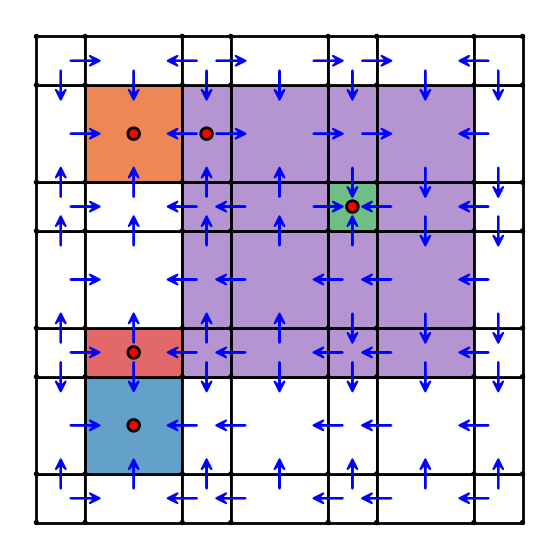

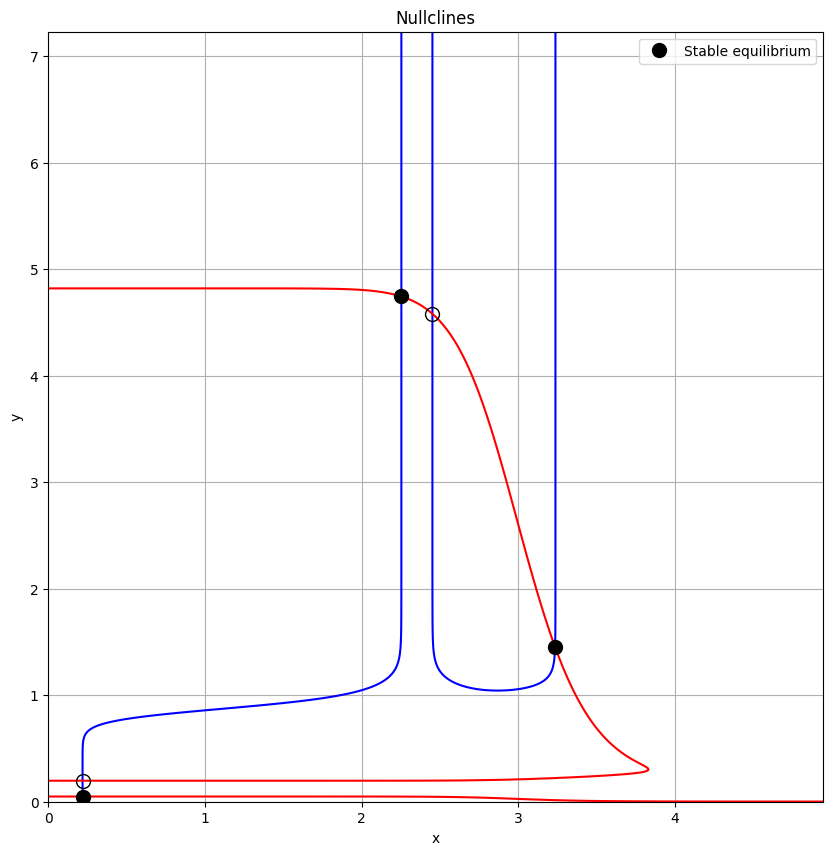

In [91]:
par_index = 98
parameter = parameter_graph.parameter(par_index)

morse_graph, stg, graded_complex = DSGRN_utils.ConleyMorseGraph(parameter)

print(DSGRN_utils.PlotMorseSets(morse_graph, stg, graded_complex))
sampler = DSGRN.ParameterSampler(network)
par_sample = sampler.sample(parameter)
# Define L, U, and T from sample
D = network.size()
L = np.zeros([D, D])
U = np.zeros([D, D])
T = np.zeros([D, D])

# Get a dictionary from sample
sample_dict = json.loads(par_sample)

# Get values of L, U, and T from dictionary
for key, value in sample_dict['Parameter'].items():
    # Get parameter (L, U, or T)
    par_type = key[0]
    # Extract variable names
    node_names = [name.strip() for name in key[2:-1].split('->')]
    node_indices = [network.index(node) for node in node_names]
    if par_type == 'L':
        L[tuple(node_indices)] = value
    elif par_type == 'U':
        U[tuple(node_indices)] = value
    else: # T
        T[tuple(node_indices)] = value

# for d in [12.0, 15.0, 20.0]:
zeros = plot_nullclines(L, U, T, 14.0)